# Import libraries

In [90]:
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Tensorflow dependencies ###
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Progbar

### Some constants ###
lr = 1e-4
batch_size = 1
epochs = 5
img_shape = (256, 256, 3)
latent_dim = 100
buffer_size = 1000

### Discriminators and Generators weights path ###
g_weights_path = "weights/g.weights.hdf5" # G : X -> Y
f_weights_path = "weights/f.weights.hdf5" # F : Y -> X
x_weights_path = "weights/x.weights.hdf5" # discriminate X and F(Y)
y_weights_path = "weights/y.weights.hdf5" # discriminate Y and G(X)

# Loading and processing data

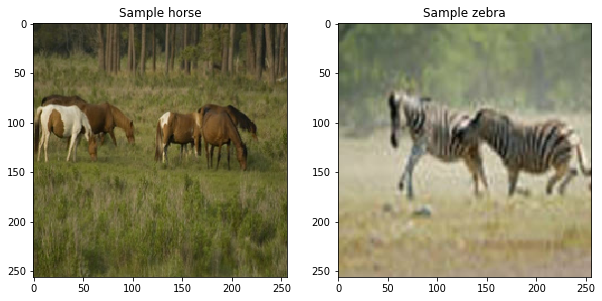

In [91]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB'] 
train_size = min(len(list(train_horses)), len(list(train_zebras)))
test_size  = min(len(list(test_horses)), len(list(test_zebras)))

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[img_shape[0], img_shape[1], 3])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 112 x 112 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image 

train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
img1 = next(iter(train_horses)).numpy()[0] * 127.5 + 127.5
img1 = img1.astype(np.uint8)
ax[0].imshow(img1)
ax[0].set_title("Sample horse")

img2 = next(iter(train_zebras)).numpy()[0] * 127.5 + 127.5
img2 = img2.astype(np.uint8)
ax[1].imshow(img2)
ax[1].set_title("Sample zebra")

plt.show()

# Model architectures

## 1. Generator G and F

In [92]:
# def make_generator(name):
#     inputs = Input(shape=(latent_dim,))
    
#     x = Dense(7*7*256, use_bias=False)(inputs)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     x = Reshape(target_shape=(7,7,256))(x)
    
#     # Size = 128 x 14 x 14 
#     x = Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same',
#                         use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Size = 64 x 28 x 28
#     x = Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same',
#                        use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Size = 32 x 56 x 56
#     x = Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), padding='same',
#                        use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Size = 16 x 112 x 112
#     x = Conv2DTranspose(16, kernel_size=(4,4), strides=(2,2), padding='same',
#                        use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Use tanh so that it is [-1, 1]
#     x = Conv2D(img_shape[-1], kernel_size=(4,4), padding='same', use_bias=False, activation='tanh')(x)
    
#     model = Model(inputs=inputs, outputs=x, name=f'Generator_{name}')
#     return model

G = pix2pix.unet_generator(img_shape[-1], norm_type='instancenorm') # make_generator('G')
F = pix2pix.unet_generator(img_shape[-1], norm_type='instancenorm') # make_generator('F')

print(G.summary())
print(F.summary())

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_144 (Sequential)     (None, None, None, 6 3072        input_9[0][0]                    
__________________________________________________________________________________________________
sequential_145 (Sequential)     (None, None, None, 1 131328      sequential_144[0][0]             
__________________________________________________________________________________________________
sequential_146 (Sequential)     (None, None, None, 2 524800      sequential_145[0][0]             
______________________________________________________________________________________

## Discriminator X and Y

In [93]:
# def make_discriminator(name):
#     inputs = Input(shape=img_shape)
    
#     x = Conv2D(16, kernel_size=(4,4), strides=(2,2), padding='same')(inputs)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(32, kernel_size=(4,4), strides=(2,2), padding='same')(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same')(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
    
#     x = Flatten()(x)
#     x = Dense(1)(x)
    
#     model = Model(inputs=inputs, outputs=x, name=f'Discriminator_{name}')
#     return model

D_x = pix2pix.discriminator(norm_type='instancenorm', target=False) # make_discriminator("X")
D_y = pix2pix.discriminator(norm_type='instancenorm', target=False) # make_discriminator("Y")

print(D_x.summary())
print(D_y.summary())

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_174 (Sequential)  (None, None, None, 64)    3072      
_________________________________________________________________
sequential_175 (Sequential)  (None, None, None, 128)   131328    
_________________________________________________________________
sequential_176 (Sequential)  (None, None, None, 256)   524800    
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, None, None, 256)   0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, None, None, 512)   2097152   
_________________________________________________________________
instance_normalization_166 ( (None, None, None, 512) 

# Define loss functions 

In [94]:
bce = BinaryCrossentropy(from_logits=True)
LAMBDA = 10.0 # scale factor for cycle consistency and identity loss functions

def generator_loss(D_fake):
    ones = tf.ones_like(D_fake, dtype=tf.float32)
    loss = bce(ones, D_fake)
    
    return loss

def discriminator_loss(D_real, D_fake):
    ones = tf.ones_like(D_real, dtype=tf.float32)
    zeros = tf.zeros_like(D_fake, dtype=tf.float32)
    
    real_loss = bce(ones, D_real)
    fake_loss = bce(zeros, D_fake)
    loss = real_loss + fake_loss
    
    return loss

def cycle_consistency_loss(cycled_images, real_images):
    return LAMBDA * tf.reduce_mean(tf.abs(cycled_images - real_images))

def identity_loss(same_images, real_images):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(same_images - real_images))

# Define training loop

In [95]:
### Preparing optimizers ###
g_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)
f_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)
x_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)
y_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)

@tf.function
def train_step(X, Y):
    ### F : Y -> X, G : X -> Y ###
    ### X : separate X and F(Y), Y : separate Y and G(X) ###
    with tf.GradientTape(persistent=True) as tape:
        # For binary crossentropy 
        fake_y = G(X, training=True)
        fake_x = F(Y, training=True)
        
        # For cycle consistency losses 
        cycled_y = F(fake_y, training=True)
        cycled_x = G(fake_x, training=True)
        
        # For identity losses 
        same_x   = F(X, training=True)
        same_y   = G(Y, training=True)
        
        D_X_real = D_x(X, training=True)
        D_Y_real = D_y(Y, training=True)
        D_X_fake = D_x(fake_x, training=True)
        D_Y_fake = D_y(fake_y, training=True)
        
        # Training generators
        bce_g = generator_loss(D_Y_fake)
        bce_f = generator_loss(D_X_fake)
        
        total_cycle_loss = cycle_consistency_loss(cycled_x, X) + cycle_consistency_loss(cycled_y, Y)
        
        identity_g = identity_loss(same_y, Y)
        identity_f = identity_loss(same_x, X)
        
        total_loss_g = bce_g + total_cycle_loss + identity_g
        total_loss_f = bce_f + total_cycle_loss + identity_f
        
        # Training discriminators 
        total_loss_Dx = discriminator_loss(D_X_real, D_X_fake)
        total_loss_Dy = discriminator_loss(D_Y_real, D_Y_fake)
        
    # Calculate gradients 
    grad_g = tape.gradient(total_loss_g, G.trainable_variables)
    grad_f = tape.gradient(total_loss_f, F.trainable_variables)
    grad_Dx = tape.gradient(total_loss_Dx, D_x.trainable_variables)
    grad_Dy = tape.gradient(total_loss_Dy, D_y.trainable_variables)
    
    # Apply gradients on trainable variables
    g_opt.apply_gradients(zip(grad_g, G.trainable_variables))
    f_opt.apply_gradients(zip(grad_f, F.trainable_variables))
    x_opt.apply_gradients(zip(grad_Dx, D_x.trainable_variables))
    y_opt.apply_gradients(zip(grad_Dy, D_y.trainable_variables))
    
    return total_loss_g, total_loss_f, total_loss_Dx, total_loss_Dy
    
def train(datasetX, datasetY):
    for i in range(epochs):
        print(f'Epoch {i+1}/{epochs}')
        batch_id = 0
        g_losses, f_losses, x_losses, y_losses = [], [], [], []
        
        # Have to re-init the progress bar after each epoch
        metric_names = ['G', 'F', 'X', 'Y']
        pbar = Progbar(train_size, stateful_metrics=metric_names, verbose=1)

        for X, Y in tf.data.Dataset.zip((datasetX, datasetY)):
            batch_id += 1
            g_loss, f_loss, x_loss, y_loss = train_step(X, Y)
            g_losses.append(g_loss)
            f_losses.append(f_loss)
            x_losses.append(x_loss)
            y_losses.append(y_loss)

            values = [('G', g_loss), ('F', f_loss), ('X', x_loss), ('Y', y_loss)]
            pbar.add(batch_size, values=values)
            if(batch_id >= train_size): break
                
        G.save_weights(g_weights_path)
        F.save_weights(f_weights_path)
        D_x.save_weights(x_weights_path)
        D_y.save_weights(y_weights_path)

train(train_horses, train_zebras)

Epoch 1/5
1067/1067 [==============================] - 232s 217ms/step - G: 10.7243 - F: 10.4663 - X: 1.3842 - Y: 1.2318
Epoch 2/5
1067/1067 [==============================] - 220s 206ms/step - G: 12.5863 - F: 12.0283 - X: 1.3927 - Y: 0.8253
Epoch 3/5


 137/1067 [==>...........................] - ETA: 3:12 - G: 11.5632 - F: 11.5940 - X: 1.1520 - Y: 1.0090 ETA: 3:29 - G: 12.5578 - F: 11.5336 - X: 1.2144 - Y: 0.50 - ETA: 3:33 - G: 12.5499 - F: 12.2275 - X: 1.6159 - Y: 1.43 - ETA: 3:34 - G: 8.9797 - F: 8.5286 - X: 1.2421 - Y: 0.7547 - ETA: 3:35 - G: 13.7805 - F: 12.3382 - X: 1.5309 - Y: 0.85 - ETA: 3:35 - G: 10.3654 - F: 10.3154 - X: 1.1483 - Y: 1.46 - ETA: 3:36 - G: 10.1290 - F: 9.3996 - X: 1.1817 - Y: 0.6580 - ETA: 3:36 - G: 12.7979 - F: 12.3285 - X: 1.1661 - Y: 0.63 - ETA: 3:36 - G: 9.5880 - F: 8.6826 - X: 1.3004 - Y: 0.7752 - ETA: 3:36 - G: 11.2043 - F: 10.3102 - X: 0.8565 - Y: 0.88 - ETA: 3:36 - G: 9.7960 - F: 9.2510 - X: 1.5066 - Y: 1.2867 - ETA: 3:36 - G: 11.5737 - F: 11.7738 - X: 1.0991 - Y: 0.67 - ETA: 3:36 - G: 8.4955 - F: 8.8365 - X: 1.5420 - Y: 0.9357 - ETA: 3:36 - G: 12.1691 - F: 12.1318 - X: 1.0678 - Y: 0.48 - ETA: 3:36 - G: 9.2845 - F: 8.0621 - X: 1.0699 - Y: 0.4344 - ETA: 3:36 - G: 12.7975 - F: 10.7652 - X: 1.0974 - Y: 0

 195/1067 [====>.........................] - ETA: 3:11 - G: 10.1488 - F: 9.8430 - X: 1.0514 - Y: 0.939 - ETA: 3:11 - G: 9.9427 - F: 8.1866 - X: 2.0459 - Y: 1.758 - ETA: 3:11 - G: 9.6964 - F: 10.1918 - X: 1.0609 - Y: 1.449 - ETA: 3:11 - G: 11.2697 - F: 11.3942 - X: 1.5093 - Y: 0.92 - ETA: 3:10 - G: 8.0186 - F: 7.9009 - X: 1.4388 - Y: 0.6960 - ETA: 3:10 - G: 8.9350 - F: 8.5051 - X: 1.0737 - Y: 0.87 - ETA: 3:10 - G: 11.7387 - F: 9.8769 - X: 1.3857 - Y: 0.328 - ETA: 3:10 - G: 9.4441 - F: 8.0696 - X: 1.2926 - Y: 0.918 - ETA: 3:10 - G: 9.4273 - F: 9.1305 - X: 1.2713 - Y: 0.82 - ETA: 3:09 - G: 15.1460 - F: 14.8428 - X: 1.2073 - Y: 1.20 - ETA: 3:09 - G: 10.8433 - F: 10.0789 - X: 1.2667 - Y: 0.80 - ETA: 3:09 - G: 11.8174 - F: 10.2655 - X: 1.1437 - Y: 0.67 - ETA: 3:09 - G: 10.7731 - F: 9.7494 - X: 0.8521 - Y: 0.6240 - ETA: 3:08 - G: 10.8880 - F: 11.0526 - X: 1.1834 - Y: 1.04 - ETA: 3:08 - G: 10.6847 - F: 10.6063 - X: 1.3376 - Y: 2.12 - ETA: 3:08 - G: 12.5970 - F: 11.7578 - X: 1.4089 - Y: 1.04 - 

KeyboardInterrupt: 

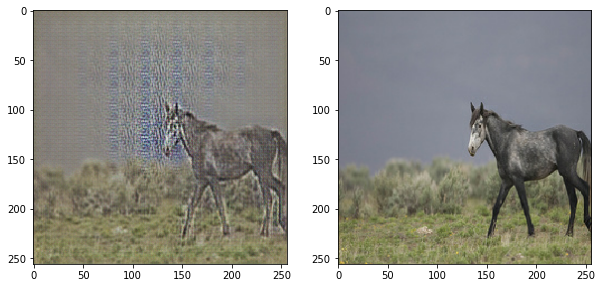

In [104]:
img = next(iter(train_horses)).numpy()

predicted = G.predict(img)[0] * 127.5 + 127.5
predicted = predicted.astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(predicted)
ax[1].imshow((img[0] * 127.5 + 127.5).astype(np.uint8))
plt.show()